# Dino Bone Finding PyTorch Model to OpenVINO for High-Performance AI Inference


<img src="assets/openVINO-OptimizationOverview.PNG" width="800"/>

This notebook demonstrates the steps in converting the dinosour bone finding PyTorch model to OpenVINO Intermediate Representation (IR) format.

First, the PyTorch model is converted and exported to ONNX. Then, the ONNX model is either fed directly into OpenVINO Runtime, or the ONNX model is then convert and optimized in the OpenVINO Intermediate Representation (IR) formats. Both ONNX and IR models are executed on OpenVINO Inference Engine to show model inferencing on CPU, iGPU and/or VPU devices interchangeably.

If you have any issues or want to contribute, please contact our authors: 

Intel OpenVINO Edge AI Software Evangelist
* Zhuo Wu, PhD [zhuo.wu (at) intel.com]  
* Raymond Lo, PhD [raymond.lo (at) intel.com] 

## Imports

In [1]:
import sys
import time
import json
import glob
import os
import collections
import zipfile

from pathlib import Path

from IPython.display import Markdown, display, Image

import cv2
import numpy as np
from PIL import Image
from openvino.runtime import Core

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable

import torchvision
from torchvision import datasets, models, transforms

## Settings

Set the name for the model. Define the path for the trained dinosaur bone finding model with PyTorch format, and the path for the converted onnx and OpenVINO IR format.

In [2]:
DIRECTORY_NAME = "models"
#BASE_MODEL_NAME = DIRECTORY_NAME + f"/resnet18-Gold20220530"
BASE_MODEL_NAME = DIRECTORY_NAME + f"/bc_resnet18_simple_NOIPEX_6Epochs_StateDict_gold"

# Paths where PyTorch, ONNX and OpenVINO IR models will be stored
model_path = Path(BASE_MODEL_NAME).with_suffix(".pt")
onnx_path = model_path.with_suffix(".onnx")
ir_path = model_path.with_suffix(".xml")

IMAGE_HEIGHT = 224
IMAGE_WIDTH = 224

## ONNX Model Conversion

The output for this cell will show some warnings. These are most likely harmless. Conversion succeeded if the last line of the output says ONNX model exported to resnet18-Gold20220530.onnx.

In [3]:
scratch_model = models.resnet18()
num_ftrs = scratch_model.fc.in_features
classes = 3
scratch_model.fc = nn.Linear(num_ftrs, classes)
#scratch_model.load_state_dict(torch.load('./models/resnet18-Gold20220530.pt'))
scratch_model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [4]:
if not onnx_path.exists():
    dummy_input = torch.randn(1, 3, IMAGE_HEIGHT, IMAGE_WIDTH)

    # For the Fastseg model, setting do_constant_folding to False is required
    # for PyTorch>1.5.1
    torch.onnx.export(
        scratch_model,
        dummy_input,
        onnx_path,
        opset_version=11,
        do_constant_folding=False,
    )
    print(f"ONNX model exported to {onnx_path}.")
else:
    print(f"ONNX model {onnx_path} already exists.")

ONNX model models/bc_resnet18_simple_NOIPEX_6Epochs_StateDict_gold.onnx already exists.


## Convert ONNX Model to OpenVINO IR Format

Call the OpenVINO Model Optimizer tool to convert the ONNX model to OpenVINO IR with FP16 precision. The models are saved to the current directory. We add the mean values to the model and scale the output with the standard deviation with --scale_values. With these options, it is not necessary to normalize input data before propagating it through the network.

See the [Model Optimizer Developer Guide](https://docs.openvino.ai/latest/openvino_docs_MO_DG_Deep_Learning_Model_Optimizer_DevGuide.html) for more information about Model Optimizer.

Executing this command may take a while. There may be some errors or warnings in the output. Model Optimization was successful if the last lines of the output include [ SUCCESS ] Generated IR version 11 model.

In [5]:
# Construct the command for Model Optimizer
mo_command = f"""mo
                 --input_model "{onnx_path}"
                 --input_shape "[1,3, {IMAGE_HEIGHT}, {IMAGE_WIDTH}]"
                 --data_type FP16
                 --output_dir "{model_path.parent}"
                 """
mo_command = " ".join(mo_command.split())
print("Model Optimizer command to convert the ONNX model to OpenVINO:")
display(Markdown(f"`{mo_command}`"))

Model Optimizer command to convert the ONNX model to OpenVINO:


`mo --input_model "models/bc_resnet18_simple_NOIPEX_6Epochs_StateDict_gold.onnx" --input_shape "[1,3, 224, 224]" --data_type FP16 --output_dir "models"`

In [6]:
if not ir_path.exists():
    print("Exporting ONNX model to IR... This may take a few minutes.")
    mo_result = %sx $mo_command
    print("\n".join(mo_result))
    if 'No such' in mo_result[0]:
        print('\n**********\n')
        print("Somthing went wrong in calling the system command:\n")
        print("1) You must launch a terminal\n")
        print("2) conda activate openvinopytorch:\n")
        print("3) invoke the mo command printed above... for example:\n")
        print('   mo --input_model "models/bc_resnet18_simple_NOIPEX_6Epochs_StateDict_gold.onnx" --input_shape "[1,3, 224, 224]" --data_type FP16 --output_dir "models" ')
        print('\n**********\n')              
else:
    print(f"IR model {ir_path} already exists.")

IR model models/bc_resnet18_simple_NOIPEX_6Epochs_StateDict_gold.xml already exists.


## Run Inference on Single Image with ONNX and IR Format and Show Results

Inference Engine can load ONNX models directly. We first load the ONNX model, do inference and show the results. After that we load the model that was converted to Intermediate Representation (IR) with Model Optimizer and do inference on that model and show the results on a single image.

In [7]:
input_size = 224
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((input_size,input_size)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((input_size,input_size)),        
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}
ImagePath = Path("assets/HFNoBone029.png")
img = Image.open(ImagePath)    
x_test = data_transforms['val'](img)[:3]   #3 channels in case png bobc
x_test.unsqueeze_(0)  # Add batch dimension
x_test2 = Variable(x_test)

### Run Inference on ONNX Format

In [8]:
# Load network to Inference Engine
core = Core()
model_onnx = core.read_model(model=onnx_path)
compiled_model_onnx = core.compile_model(model=model_onnx, device_name="CPU")

output_layer_onnx = compiled_model_onnx.output(0)

# Run inference on the input image
res_onnx = compiled_model_onnx([x_test2])[output_layer_onnx]

In [9]:
# print out the inference results using the onnx model format
print("inference result using onnx format for the 3 classes are ", res_onnx)

inference result using onnx format for the 3 classes are  [[ 7.865317  -3.2531433 -4.9001904]]


In [10]:
def softmax(x):
    """
    Compute the softmax of vector x.
    """
    exp_x = np.exp(x)
    softmax_x = exp_x / np.sum(exp_x)
    return softmax_x 

In [11]:
class_names = ['0', '1', '2']
predArgmax = np.argmax(res_onnx)
confidence = softmax(res_onnx)
score = []
score.append(class_names[predArgmax] )
score.append(float(confidence[0][predArgmax]) )

In [12]:
# print out the final score, including the class name for the input map image, and its confidence level
print(score)

['0', 0.9999823570251465]


### Run Inference on IR Format

This will run the model on the CPU using OpenVINO Runtime

In [13]:
# Load the network in Inference Engine
core = Core()
model_ir = core.read_model(model=ir_path)
compiled_model_ir = core.compile_model(model=model_ir, device_name="CPU")

# Get input and output layers
output_layer_ir = compiled_model_ir.output(0)

# Run inference on the input image
res_ir = compiled_model_ir([x_test2])[output_layer_ir]

In [14]:
# print out the inference results using the IR model format
print("inference result using IR format for the 3 classes are ", res_ir)

inference result using IR format for the 3 classes are  [[ 7.866906  -3.2507515 -4.900574 ]]


In [15]:
predArgmax = np.argmax(res_ir)
confidence = softmax(res_ir)
score = []
score.append(class_names[predArgmax] )
score.append(float(confidence[0][predArgmax]) )

In [16]:
# print out the final score, including the class name for the input map image, and its confidence level
print(score)

['0', 0.9999822974205017]


### PyTorch Score Comparison

Compare the inference results using the PyTorch model format

In [17]:
with torch.no_grad():
    result_torch = scratch_model(x_test2)

predArgmax = torch.argmax(result_torch[0]).numpy()
confidence = F.softmax(result_torch, dim=0)
score = []
score.append( class_names[predArgmax] )
score.append( float(confidence[0][predArgmax]) )

In [18]:
# print out the final score, including the class name for the input map image, and its confidence level
print(score)

['1', 1.0]


## Performance Comparison

Measure the time it takes to perform inference on a few hundred images. This gives an indication of performance. For more accurate benchmarking, please use the OpenVINO Benchmark Tool. Note that many optimizations are possible to improve the performance. See examples:  https://github.com/openvinotoolkit/openvino_notebooks/blob/main/notebooks/104-model-tools/104-model-tools.ipynb

In [19]:
num_images = 400

input_image = x_test2

start = time.perf_counter()
for _ in range(num_images):
    compiled_model_onnx([x_test2])
end = time.perf_counter()
time_onnx = end - start
print(
    f"ONNX model in Inference Engine/CPU: {time_onnx/num_images:.5f} "
    f"seconds per image, FPS: {num_images/time_onnx:.2f}"
)

start = time.perf_counter()
for _ in range(num_images):
    compiled_model_ir([input_image])
end = time.perf_counter()
time_ir = end - start
print(
    f"IR model in Inference Engine/CPU: {time_ir/num_images:5f} "
    f"seconds per image, FPS: {num_images/time_ir:.2f}"
)

with torch.no_grad():
    start = time.perf_counter()
    for _ in range(num_images):
        scratch_model(input_image)
    end = time.perf_counter()
    time_torch = end - start
print(
    f"PyTorch model on CPU: {time_torch/num_images:.5f} seconds per image, "
    f"FPS: {num_images/time_torch:.2f}"
)

if "GPU" in core.available_devices:
    num_images = 2000

    compiled_model_onnx_gpu = core.compile_model(model=model_onnx, device_name="GPU")
    #warm up
    compiled_model_onnx_gpu([input_image])

    start = time.perf_counter()
    for _ in range(num_images):
        compiled_model_onnx_gpu([input_image])
    end = time.perf_counter()
    time_onnx_gpu = end - start
    print(
        f"ONNX model in Inference Engine/GPU: {time_onnx_gpu/num_images:.5f} "
        f"seconds per image, FPS: {num_images/time_onnx_gpu:.2f}"
    )

    compiled_model_ir_gpu = core.compile_model(model=model_ir, device_name="GPU")
    #warm up
    compiled_model_ir_gpu([input_image])

    start = time.perf_counter()
    for _ in range(num_images):
        compiled_model_ir_gpu([input_image])
    end = time.perf_counter()
    time_ir_gpu = end - start
    print(
        f"IR model in Inference Engine/GPU: {time_ir_gpu/num_images:.5f} "
        f"seconds per image, FPS: {num_images/time_ir_gpu:.2f}"
    )

ONNX model in Inference Engine/CPU: 0.00535 seconds per image, FPS: 186.84
IR model in Inference Engine/CPU: 0.005248 seconds per image, FPS: 190.54
PyTorch model on CPU: 0.02390 seconds per image, FPS: 41.83


## Results of Inference on Image Folder and Map Merging

Best map to score
Green square roughly 265 m x 265 m -  about 2.5 football or soccer fields long
The are in Green is a significantly smaller search are than the entire map

Run Inference on the whole folder of 224 maps and merge the final results into a big map.
Compare the results with inference on ONNX, IR files and Pytorch format with CPU.

In [20]:
def image_preprocessing(ImagePath):
    """Preprocessing for the input aerial 224*224 map image.
    """
    img = Image.open(ImagePath)    
    x_test = data_transforms['val'](img)[:3]   #3 channels in case png bobc
    x_test.unsqueeze_(0)  # Add batch dimension
    x_test2 = Variable(x_test)
    return x_test2

In [21]:
def scoreSingleImage_ir(ImagePath, compiled_model_ir, output_layer_ir, dataset_classes):
    """Run inference on single image with IR format.
    """
    x_test2 = image_preprocessing(ImagePath)
    
    start_infer = time.perf_counter()
    # Run inference on the input image
    res_ir = compiled_model_ir([x_test2])[output_layer_ir]
    stop_infer = time.perf_counter()
    time_infer = stop_infer - start_infer
    
    predArgmax = np.argmax(res_ir)
    confidence = softmax(res_ir)
    score = []
    score.append(class_names[predArgmax] )
    score.append(float(confidence[0][predArgmax]) )
    return score, time_infer

In [22]:
def scoreSingleImage_torch(ImagePath, model, dataset_classes):
    """Run inference on single image with PyTorch format.
    """
    model.eval()
    x_test2 = image_preprocessing(ImagePath)
    
    start_infer = time.perf_counter()
    output = model(x_test2)
    stop_infer = time.perf_counter()
    time_infer = stop_infer - start_infer

    class_names = dataset_classes
    predArgmax = torch.argmax(output[0]).numpy()
    confidence = F.softmax(output, dim=0)
    score = []
    score.append( class_names[predArgmax] )
    score.append( float(confidence[0][predArgmax]) )
    return score, time_infer 

In [23]:
def result_to_map(pred, filenameMap):
    """Color each 224 * 224 map with inference results corresponded colors.
       Green for 'Bones highly likely', lightGreen for 'Bones possible', and white for 'No Bones'.
    """
    if pred[0] == '2':
        Image.alpha_composite(img.convert("RGBA"), green).save(filenameMap)
    elif pred[0] == '1': 
        Image.alpha_composite(img.convert("RGBA"), lightGreen).save(filenameMap)
    else:
        Image.alpha_composite(img.convert("RGBA"), black).save(filenameMap)

In [24]:
import os

# Check whether the specified path exists or not
path = 'assets/224Map'
isExist = os.path.exists(path)

if not isExist:
  # Create a new directory because it does not exist 
    os.makedirs(path)
    print(f"{path} directory is created!")  
    
path = 'assets/224Map_auto'
isExist = os.path.exists(path)

if not isExist:
  # Create a new directory because it does not exist 
    os.makedirs(path)
    print(f"{path} directory is created!") 


In [25]:
def save_merge_map(merge_path):
    """ Merge the 224 * 224 map into a large map for the final bone finding results.
    """
    map_save = merge_path
    xblock = 17
    yblock = 15
    dst = Image.new('RGB', ((xblock - 1)*224, (yblock - 1)*224))
    for x in range(xblock):
        for y in range(yblock):
            path = 'assets/224Map/DNM_x{:02d}y{:02d}.png'.format(x,y)
            img = Image.open(path)
            dst.paste(img, (x*224, y*224))
            img.close()
    dst.save(map_save)
    print(map_save)
    print("Done!")
def show_im(path):
    scale = 0.25
    display_image = Image.open(path)
    display(display_image.resize(( int(display_image.width * scale), int(display_image.height * scale))))

In [26]:
green = Image.new('RGBA',(224,224),(0,255,0,60))
white = Image.new('RGBA',(224,224),(255,255,255,1))
lightGreen = Image.new('RGBA',(224,224),(0,255,0,20))
black = Image.new('RGBA',(224,224),(0,0,0,1))

my_classes = ['0', '1', '2']

lookup = {'0': 'No Bones',
          '1': 'Bones possible',
          '2': 'Bones highly likely'
         }

# Running inference on the input images with PyTorch 

We will run the OpenVINO and PyTorch results side-by-side to compare the output results. Again, the true performance gain is much more visible once we increase the input size (e.g., 10000 of image patches).

In [27]:
scratch_model = models.resnet18(pretrained=True)
num_ftrs = scratch_model.fc.in_features
classes = 3
scratch_model.fc = nn.Linear(num_ftrs, classes)
#scratch_model.load_state_dict(torch.load('./models/resnet18-Gold20220530.pt'))
scratch_model.load_state_dict(torch.load(model_path))

score_torch = []

start_time = time.perf_counter()
infer_time_sum = 0
xblock = 17
yblock = 15
for x in range(xblock):
    for y in range(yblock):
        filename = 'assets/224/DNM_x{:02d}y{:02d}.jpg'.format(x, y)
        filenameMap = 'assets/224Map/DNM_x{:02d}y{:02d}.png'.format(x, y)
        img = Image.open(filename)
        try: 
            pred, time_infer = scoreSingleImage_torch(filename, scratch_model, my_classes)
            infer_time_sum += time_infer
            score_torch.append(pred)
            # print out the predicted class names for the input images
            # print(filename.split('/')[-1], lookup[pred[0]]) 
            result_to_map(pred, filenameMap)
        except:
            print ("Problem", x, y, filename)

print("Scoring time elapsed for PyTorch:", round(time.perf_counter() - start_time, 4), "s") 
print("Inferencing time elapsed for PyTorch:", round(infer_time_sum, 4), "s") 

Scoring time elapsed for PyTorch: 11.1271 s
Inferencing time elapsed for PyTorch: 5.4597 s


assets/DNM_ThreeClassBalanced_PyTorch.jpg
Done!


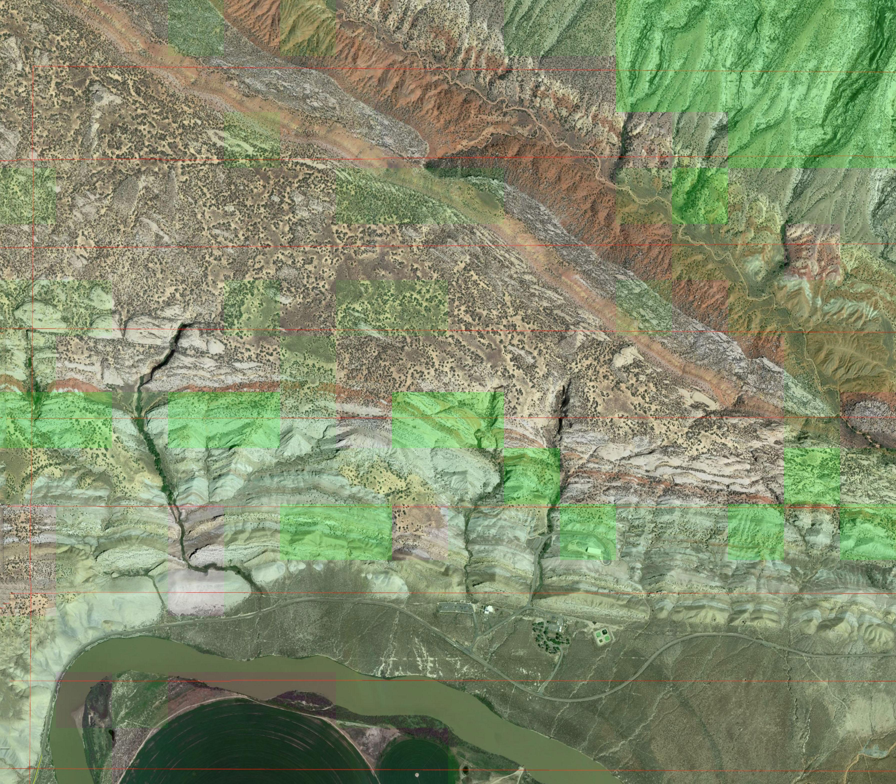

In [28]:
merge_path = 'assets/DNM_ThreeClassBalanced_PyTorch.jpg'
save_merge_map(merge_path)
show_im(merge_path)

# Running inference on the input images with OpenVINO 
This will run the inference on OpenVINO. If GPU is available, you can switch the device_name to "GPU" to offload work to GPU. In this case, we defined the "AUTO" and the workload will automatically distributed to the iGPU.

Note: A larger sample size (1000+) is needed for benchmarking the performance. The performance below is for quick reference only for validating the data is accurate.

In [29]:
compiled_model_ir_cpu_gpu = core.compile_model(model=model_ir, device_name="AUTO")
output_layer_ir = compiled_model_ir_cpu_gpu.output(0)
score_ir = []
start_time = time.perf_counter()
infer_time_sum = 0
xblock = 17
yblock = 15
for x in range(xblock):
    for y in range(yblock):
        filename = 'assets/224/DNM_x{:02d}y{:02d}.jpg'.format(x, y)
        filenameMap = 'assets/224Map/DNM_x{:02d}y{:02d}.png'.format(x, y)
        img = Image.open(filename)
        try: 
            pred, time_infer = scoreSingleImage_ir(filename, compiled_model_ir_cpu_gpu, output_layer_ir, my_classes)
            infer_time_sum += time_infer
            score_ir.append(pred)
            # print out the predicted class names for the input images
            # print(filename.split('/')[-1], lookup[pred[0]])
            result_to_map(pred, filenameMap)
        except:
            print ("Problem", x, y, filename)
print("Scoring time elapsed for OpenVINO:", round(time.perf_counter() - start_time, 4), "s") 
print("Inferencing time elapsed for OpenVINO:", round(infer_time_sum, 4), "s") 

Scoring time elapsed for OpenVINO: 8.3606 s
Inferencing time elapsed for OpenVINO: 3.481 s


In [ ]:
merge_path = 'assets/DNM_ThreeClassBalanced_OpenVINO.jpg'
save_merge_map(merge_path)
show_im(merge_path)

assets/DNM_ThreeClassBalanced_OpenVINO.jpg
Done!


# Compare the results/accuracy between PyTorch and OpenVINO inference results

We will check if scores from both models match (i.e., validating no loss in accuracy).

In [ ]:
counter = 0
for k in range(len(score_torch)):
    if score_torch[k][0] != score_ir[k][0]:
        counter += 1
        print('comparing between pytorch and ir')
        print(k)
        print(score_torch[k][0])
        print(score_ir[k][0])
print('The number of mismatch is', counter)

## To learn more about OpenVINO. Try the demo link below.
* https://github.com/openvinotoolkit/openvino_notebooks

To further optimize the model, you can try Post Training Optimization Tools (demo below):
* [Post-Training Quantization of PyTorch models with NNCF](https://github.com/openvinotoolkit/openvino_notebooks/blob/main/notebooks/112-pytorch-post-training-quantization-nncf/112-pytorch-post-training-quantization-nncf.ipynb)

## Notices and Disclaimers

Intel technologies may require enabled hardware, software or service activation.

No product or component can be absolutely secure. 

Your costs and results may vary. 

© Intel Corporation. Intel, the Intel logo, and other Intel marks are trademarks of Intel Corporation or its subsidiaries. Other names and brands may be claimed as the property of others. 